In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

### Data input and processing

In [3]:
def standard_error(series):
    return series.std() / np.sqrt(series.count())

def process_data(new_file_path, previous_df=None):
    """
    Processes the experiment data from a new CSV file. If a previous DataFrame is provided,
    appends the new data to it; otherwise, creates a new DataFrame.

    Parameters:
    previous_df (pandas.DataFrame, optional): The existing DataFrame to append to. Defaults to None.
    new_file_path (str): The file path to the new CSV file containing the experiment data.

    Returns:
    pandas.DataFrame: A DataFrame with the combined data.
    """
    # Load the data from the new CSV file
    new_data = pd.read_csv(new_file_path)

    # Add other model name mappings as needed
    model_name_mappings = {
    'meta-llama/Llama-2-7b-chat-hf': 'Llama 2 (7b)',
    'EleutherAI/pythia-1b': 'Pythia (1b)',
    'EleutherAI/pythia-6.9b': 'Pythia (6.9b)',
    'EleutherAI/pythia-2.8b': 'Pythia (2.8b)',
    'EleutherAI/pythia-480m': 'Pythia (480m)'
    }

    # Add a new column for method_name based on the value of method
    new_data['method_name'] = new_data.apply(lambda x: x['prune_method'] if x['method'] == 'prune' else x['quant_method'] if x['method'] == 'quant' else None, axis=1)
    new_data['method_name'] = new_data['method_name'].replace({'autoawq': 'AWQ', 'autogptq': 'GPTQ', 'sparsegpt': 'SparseGPT', 'wanda': 'Wanda'})
    new_data['model'] = new_data['model'].replace(model_name_mappings)

    # Check if 'PPL edits' column exists
    if 'PPL edits' in new_data.columns:
        aggregation_columns = ['Rewrite accuracy', 'PPL', 'Generalization', 'Latency', 'Locality', 'PPL edits', 'PPl edits unmasked']
    else:
        aggregation_columns = ['Rewrite accuracy', 'PPL', 'Generalization', 'Latency', 'Locality']
        # print(new_data.columns)
        # new_data['PPL edits'] = np.nan  # Create an empty 'PPL edits' column


    # Group by 'Tags' and calculate mean and standard error for the selected columns
    grouped_new_data = new_data.groupby('Tags')[aggregation_columns].agg(['mean', standard_error])

    # Flatten multi-level columns and rename them
    grouped_new_data.columns = ['_'.join(col).strip() for col in grouped_new_data.columns.values]

    # Merge the grouped new data with the extracted information
    final_new_df = pd.merge(grouped_new_data.reset_index(), new_data[['Tags', 'alg_name', 'model', 'edit', 'compress', 'sparsity_ratio', 'method_name', 'Average bits']], 
                            on='Tags', how='left').drop_duplicates(subset='Tags')


    # Reordering columns
    final_cols = ['alg_name', 'model', 'edit', 'compress', 'Tags', 'sparsity_ratio', 'method_name'] + \
                 [col for col in final_new_df.columns if col not in ['alg_name', 'model', 'edit', 'compress', 'sparsity_ratio', 'Tags', 'method_name']]
    final_new_df = final_new_df[final_cols]

    # If a previous DataFrame is provided, append the new data; otherwise, use the new data as the DataFrame
    if previous_df is not None:
        combined_df = pd.concat([previous_df, final_new_df], ignore_index=True)
    else:
        combined_df = final_new_df

    return combined_df

In [4]:
## Counterfact

# No edits
unedited_counterfact = process_data('data/counterfact/none.csv')
unedited_counterfact = process_data('data/counterfact/noedit_compress.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/noedit_compress_extra.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/W4_GPTQ.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/W8_GPTQ.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/W4_AWQ.csv', unedited_counterfact)

# With MEMIT
edited_counterfact = process_data('data/counterfact/memit.csv')
edited_counterfact = process_data('data/counterfact/edit_compress.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/edit_compress_extra.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/W4_Edits_GPTQ.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/W8_Edits_GPTQ.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/W4_Edits_AWQ.csv', edited_counterfact)

# Compress First
compfirst_counterfact = process_data('data/counterfact/memit.csv')
compfirst_counterfact = process_data('data/counterfact/compress_first.csv', compfirst_counterfact)
compfirst_counterfact = process_data('data/counterfact/W3_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)
compfirst_counterfact = process_data('data/counterfact/W4_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)
compfirst_counterfact = process_data('data/counterfact/W8_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)

models = ['Pythia1b']
for model in models:
    model_path = f'data/counterfact/{model}/'

    # No edits
    unedited_counterfact = process_data(model_path + 'none.csv', unedited_counterfact)
    unedited_counterfact = process_data(model_path + 'noedit_compress.csv', unedited_counterfact)
    unedited_counterfact = process_data(model_path + 'W8_GPTQ.csv', unedited_counterfact)
    unedited_counterfact = process_data(model_path + 'W4_GPTQ.csv', unedited_counterfact)
    unedited_counterfact = process_data(model_path + 'W4_AWQ.csv', unedited_counterfact)
    unedited_counterfact = process_data(model_path + 'W3_GPTQ.csv', unedited_counterfact)

    # With MEMIT
    edited_counterfact = process_data(model_path + 'memitonly.csv', edited_counterfact)
    edited_counterfact = process_data(model_path + 'edit_compress.csv', edited_counterfact)
    edited_counterfact = process_data(model_path + 'W8_Edits_GPTQ.csv', edited_counterfact)
    edited_counterfact = process_data(model_path + 'W4_Edits_GPTQ.csv', edited_counterfact)
    edited_counterfact = process_data(model_path + 'W4_Edits_AWQ.csv', edited_counterfact)
    edited_counterfact = process_data(model_path + 'W3_Edits_GPTQ.csv', edited_counterfact)

    # Compress First
    compfirst_counterfact = process_data(model_path + 'memitonly.csv', compfirst_counterfact)
    compfirst_counterfact = process_data(model_path + 'compress_first.csv', compfirst_counterfact)
    compfirst_counterfact = process_data(model_path + 'W8_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)
    compfirst_counterfact = process_data(model_path + 'W4_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)
    compfirst_counterfact = process_data(model_path + 'W3_GPTQ_Edits_GPTQ.csv', compfirst_counterfact)

## ZSRE

# No edits
unedited_zsre = process_data('data/zsre/none.csv')
unedited_zsre = process_data('data/zsre/noedit_compress.csv', unedited_zsre)
unedited_zsre = process_data('data/zsre/noedit_compress_extra.csv', unedited_zsre)
unedited_zsre = process_data('data/zsre/W4_GPTQ.csv', unedited_zsre)  # Updated file name
unedited_zsre = process_data('data/zsre/W8_GPTQ.csv', unedited_zsre)  # Updated file name
unedited_zsre = process_data('data/zsre/W4_AWQ.csv', unedited_zsre)  # Updated file name

# With MEMIT
edited_zsre = process_data('data/zsre/memit.csv')
edited_zsre = process_data('data/zsre/edit_compress.csv', edited_zsre)
edited_zsre = process_data('data/zsre/edit_compress_extra.csv', edited_zsre)
edited_zsre = process_data('data/zsre/W4_Edits_GPTQ.csv', edited_zsre)  # Updated file name
edited_zsre = process_data('data/zsre/W8_Edits_GPTQ.csv', edited_zsre)  # Updated file name
edited_zsre = process_data('data/zsre/W4_Edits_AWQ.csv', edited_zsre)  # Updated file name

# Compress first
compfirst_zsre = process_data('data/zsre/compress_first.csv')
compfirst_zsre = process_data('data/zsre/memit_only.csv', compfirst_zsre)
compfirst_zsre = process_data('data/zsre/W8_GPTQ_Edits_GPTQ.csv', compfirst_zsre)
compfirst_zsre = process_data('data/zsre/W4_GPTQ_Edits_GPTQ.csv', compfirst_zsre)

## MQ

# No edits
unedited_mq = process_data('data/MQ/noedit_compress.csv')
unedited_mq = process_data('data/MQ/noedit_compress_extra.csv', unedited_mq)
unedited_mq = process_data('data/MQ/W4_GPTQ.csv', unedited_mq)
unedited_mq = process_data('data/MQ/W8_GPTQ.csv', unedited_mq)
unedited_mq = process_data('data/MQ/W4_AWQ.csv', unedited_mq)

# With MEMIT
edited_mq = process_data('data/MQ/edit_compress.csv')
edited_mq = process_data('data/MQ/edit_compress_extra.csv', edited_mq)
edited_mq = process_data('data/MQ/W4_Edits_GPTQ.csv', edited_mq)
edited_mq = process_data('data/MQ/W8_Edits_GPTQ.csv', edited_mq)
edited_mq = process_data('data/MQ/W4_Edits_AWQ.csv', edited_mq)
edited_mq = process_data('data/MQ/W3_Edits_GPTQ.csv', edited_mq)

# Compress first
compfirst_mq = process_data('data/MQ/compress_first.csv')
compfirst_mq = process_data('data/MQ/memit_only.csv', compfirst_mq)
compfirst_mq = process_data('data/MQ/W8_GPTQ_Edits_GPTQ.csv', compfirst_mq)
compfirst_mq = process_data('data/MQ/W4_GPTQ_Edits_GPTQ.csv', compfirst_mq)
compfirst_mq = process_data('data/MQ/W3_GPTQ_Edits_GPTQ.csv', compfirst_mq)



In [5]:
print(unedited_counterfact.columns)
print(unedited_counterfact.shape)
print(unedited_counterfact[0:2]['Average bits'])
# print(edited_counterfact[edited_counterfact['method_name'] == 'SparseGPT'].head(50)[['PPL_mean', 'Average bits', 'model', 'PPl edits unmasked_mean']])
# print(compfirst_counterfact['model'].unique())

df = edited_counterfact

# Select the two rows to compare
row1 = df.iloc[0]
row2 = df.iloc[1]

# Compare the rows
differences = row1 != row2

# Print the columns where the rows differ
different_columns = differences[differences].index.tolist()
print("Columns where the rows differ:", different_columns)

# Optionally, print the differing values in these columns for both rows
for column in different_columns:
    print(f"Column: {column}, Row 1: {row1[column]}, Row 2: {row2[column]}")

Index(['alg_name', 'model', 'edit', 'compress', 'Tags', 'sparsity_ratio',
       'method_name', 'Rewrite accuracy_mean',
       'Rewrite accuracy_standard_error', 'PPL_mean', 'PPL_standard_error',
       'Generalization_mean', 'Generalization_standard_error', 'Latency_mean',
       'Latency_standard_error', 'Locality_mean', 'Locality_standard_error',
       'PPL edits_mean', 'PPL edits_standard_error', 'PPl edits unmasked_mean',
       'PPl edits unmasked_standard_error', 'Average bits'],
      dtype='object')
(37, 22)
0    15.999980
1    12.249977
Name: Average bits, dtype: float64
Columns where the rows differ: ['compress', 'Tags', 'sparsity_ratio', 'Rewrite accuracy_mean', 'Rewrite accuracy_standard_error', 'PPL_mean', 'PPL_standard_error', 'Generalization_mean', 'Generalization_standard_error', 'Latency_mean', 'Latency_standard_error', 'Locality_mean', 'Locality_standard_error', 'PPL edits_mean', 'PPL edits_standard_error', 'PPl edits unmasked_mean', 'PPl edits unmasked_standard_er

### Metrics vs avg bits

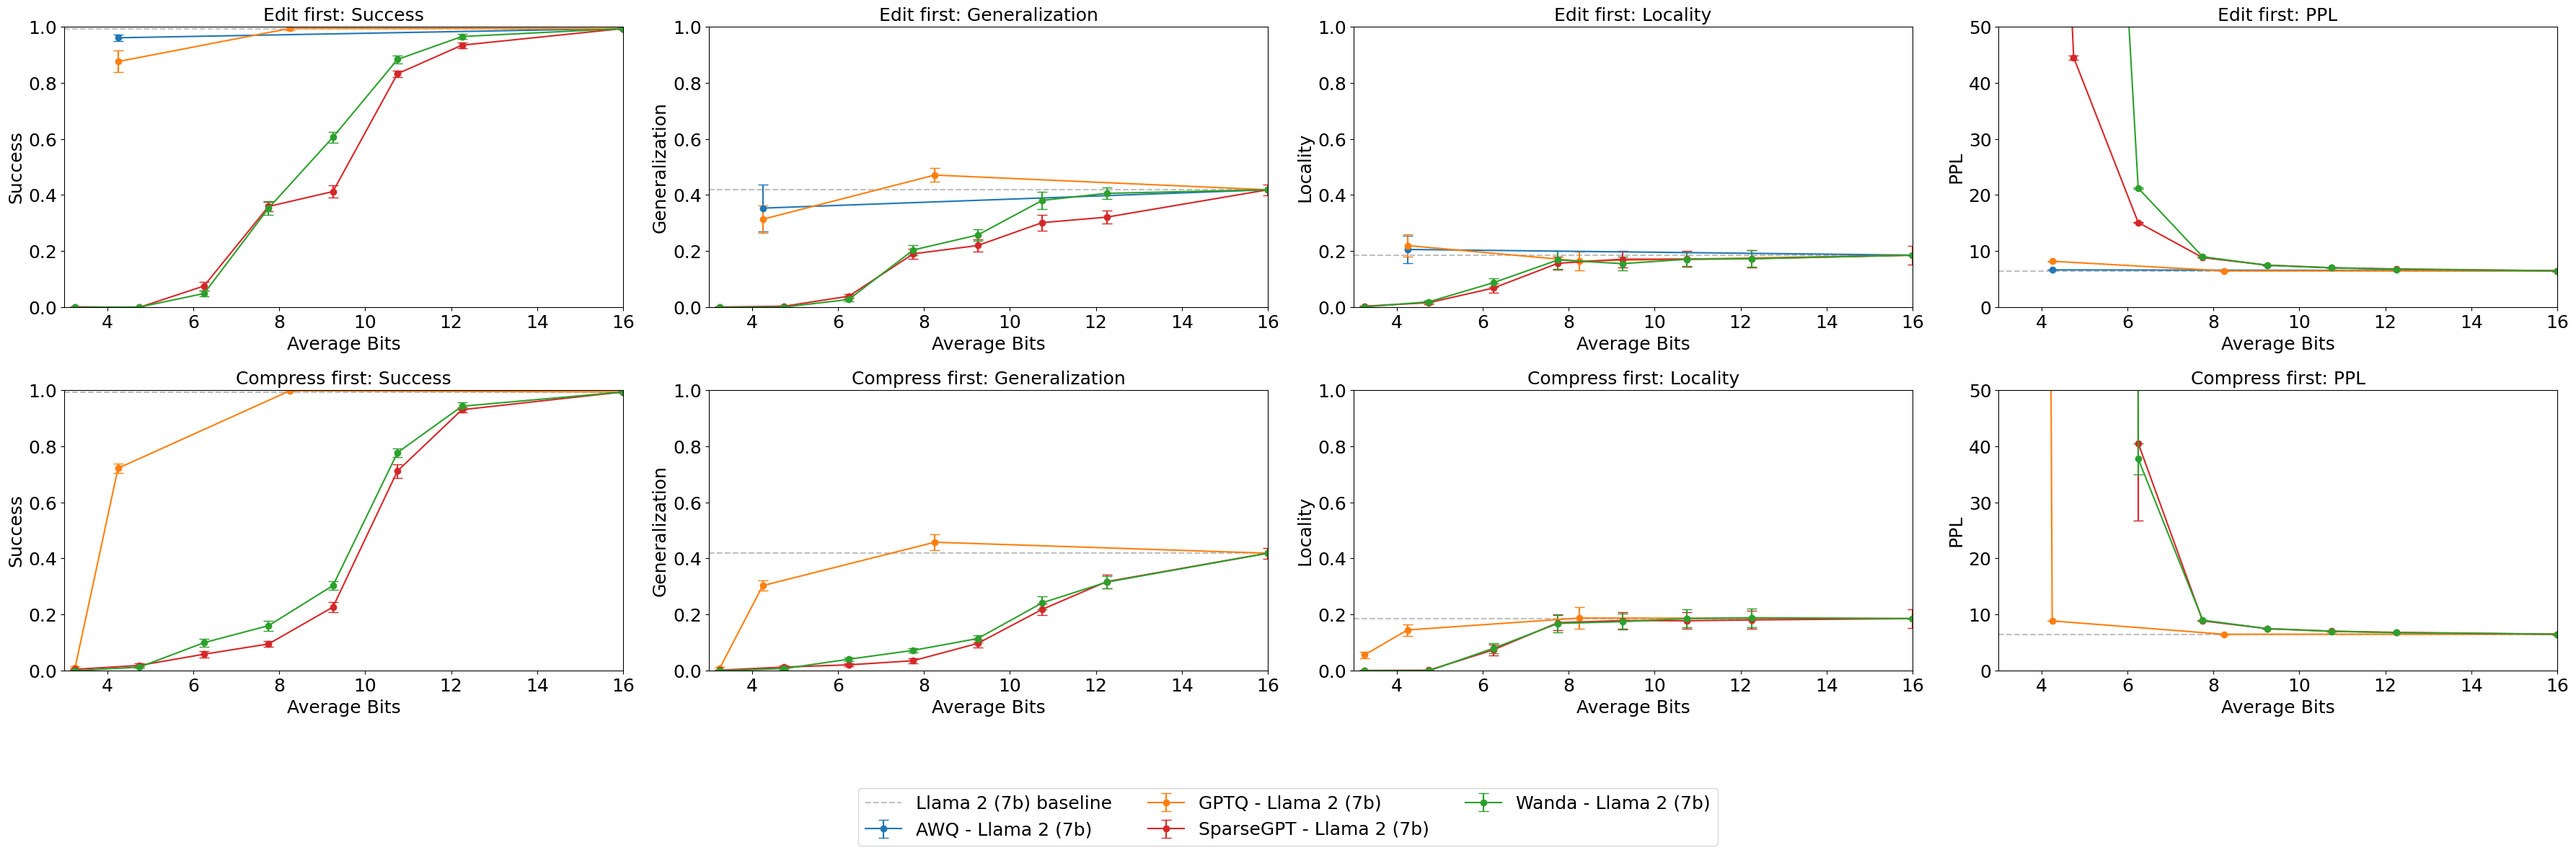

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_metrics(dataframes, titles, metrics, included_models):
    num_dfs = len(dataframes)
    fig, axs = plt.subplots(num_dfs, len(metrics), figsize=(36, 6 * num_dfs))
    
    # Define font sizes
    title_fontsize = 18
    label_fontsize = 18
    legend_fontsize = 18
    tick_fontsize = 18

    all_methods = set(method for df in dataframes for method in df['method_name'].unique())
    all_models = set(model for model in included_models)
    method_colors = {method: f'C{i}' for i, method in enumerate(all_methods)}
    model_markers = {model: marker for model, marker in zip(all_models, ['o', 's', '^', 'D', 'v', '<', '>', 'p'])}

    for df_index, df in enumerate(dataframes):
        df = df[df['model'].isin(included_models)]
        df_baselines = {model: {metric: df[(df['model'] == model) & (df['sparsity_ratio'] == 0)][metric].mean() for metric in metrics} for model in included_models}

        for i, metric in enumerate(metrics):
            ax = axs[df_index, i]
            ylabel = 'Success' if 'Rewrite accuracy' in metric else metric.split('_')[0]
            if titles[df_index] == 'MQuAKE':
                ylabel = 'One-hop' if 'Locality' in metric else metric.split('_')[0]

            # Plot baselines for each model
            for model, baselines in df_baselines.items():
                baseline_value = baselines.get(metric, 0)
                ax.axhline(y=baseline_value, color='gray', linestyle='--', alpha=0.5, label=f"{model} baseline")

            # Plot data for each method-model combination
            method_model_grouped = df.groupby(['method_name', 'model'])
            for (method, model), group in method_model_grouped:
                label = f"{method} - {model}"
                color = method_colors[method]
                marker_style = model_markers[model] + '-'
                baseline_value = df_baselines[model].get(metric, 0)

                new_data = pd.DataFrame({'Average bits': [16], metric: [baseline_value]})
                extended_method_data = pd.concat([group, new_data], ignore_index=True)
                extended_method_data_sorted = extended_method_data.sort_values(by='Average bits', ascending=False)

                ax.errorbar(extended_method_data_sorted['Average bits'], extended_method_data_sorted[metric], 
                            yerr=extended_method_data_sorted[metric.replace('mean', 'standard_error')].fillna(0), 
                            fmt=marker_style, color=color, label=label, capsize=5)

            # Set labels, titles, etc.
            ax.set_xlabel('Average Bits', fontsize=label_fontsize)
            ax.set_ylabel(ylabel, fontsize=label_fontsize)
            ax.set_title(f'{titles[df_index]}: {ylabel}', fontsize=title_fontsize)
            ax.grid(False)
            ax.set_xlim(3, 16)
            ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
            if i < 3:
                ax.set_ylim(0, 1)
            else:
                ax.set_ylim(0, 50)
            # secax = ax.secondary_xaxis('bottom')
            # secax.set_xlabel('Percentage Pruned', fontsize=label_fontsize)
            # secax.set_xticks([1, 4.75, 8.25, 12.25, 16])
            # secax.set_xticklabels(['100%', '75%', '50%', '25%', '0%'], fontsize=tick_fontsize)

    # Consolidate legend entries
    handles, labels = [], []
    unique_labels = set()
    for ax in axs.flat:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in unique_labels:
                handles.append(handle)
                labels.append(label)
                unique_labels.add(label)

    # Place the legend at the bottom of the figure
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.0), fontsize=legend_fontsize)
    
    plt.tight_layout(rect=[0, 0.14, 1, 1])
    plt.savefig('figures/counterfact_lines.pdf', format='pdf', dpi=300)  # Save as PDF
    plt.show()

# Example usage
# More models: 'EleutherAI/pythia-1b' 'EleutherAI/pythia-2.8b', 'meta-llama/Llama-2-7b-chat-hf', , 'Pythia (1b)'
included_models = ['Llama 2 (7b)']
dfs = [edited_counterfact, compfirst_counterfact]
metrics = ['Rewrite accuracy_mean', 'Generalization_mean', 'Locality_mean', 'PPL_mean']
titles = ['Edit first', 'Compress first', 'No edit']
plot_metrics(dfs, titles, metrics, included_models)


### Metrics vs NLL

True
Success
False
Generalization
False
Locality
False
PPL


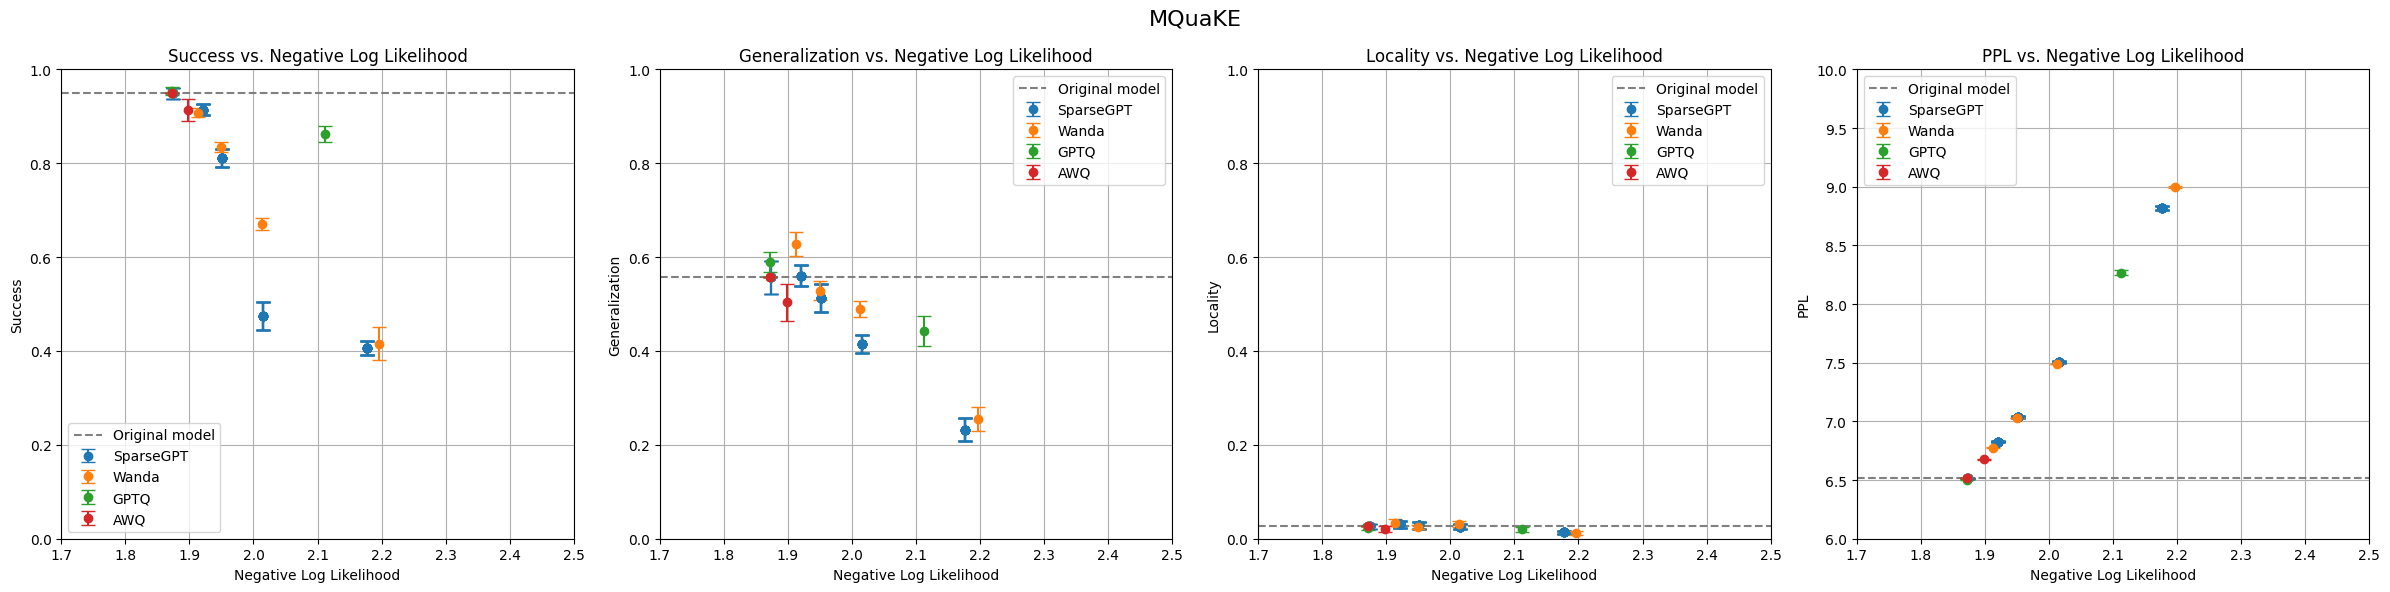

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')  # Load your DataFrame here

df = edited_mq  # Use your DataFrame

metrics = ['Rewrite accuracy_mean', 'Generalization_mean', 'Locality_mean', 'PPL_mean']

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Extract baseline values for each metric
baseline_values = {metric: df[df['sparsity_ratio'] == 0][metric].mean() for metric in metrics}

# Compute NLL from PPL
df['NLL'] = np.log(df['PPL_mean'])

for i, metric in enumerate(metrics):
    # Change the label 'Rewrite accuracy' to 'Success'
    # print(metric)
    print( 'Rewrite' in metric)
    ylabel = 'Success' if 'Rewrite' in metric else metric.split('_')[0]
    # print(ylabel)
    ylabel = 'One-hop' if 'Locality' in metric else metric.split('_')[0]

    # Plot baseline as a horizontal dotted line
    axs[i].axhline(y=baseline_values[metric], color='gray', linestyle='--', label='Original model')

    # Plot each method in the dataset, including a baseline point at the start
    for method in df['method_name'].unique():
        method_data = df[df['method_name'] == method]
        # Prepend the baseline data point
        baseline_data = pd.DataFrame({'NLL': [df['NLL'].min()], metric: [baseline_values[metric]]})
        method_data = pd.concat([baseline_data, method_data], ignore_index=True)
        axs[i].errorbar(method_data['NLL'], method_data[metric], 
                        yerr=method_data[metric.replace('mean', 'standard_error')].fillna(0), 
                        fmt='o', label=method, capsize=5)

    axs[i].set_xlabel('Negative Log Likelihood')
    ylabel = 'Success' if 'Rewrite' in metric else metric.split('_')[0]
    print(ylabel)
    axs[i].set_ylabel(ylabel)
    axs[i].set_title(f'{ylabel} vs. Negative Log Likelihood')
    axs[i].legend()
    axs[i].grid(True)

    # Adjust y-axis limits
    if i < 3:
        axs[i].set_ylim(0, 1)
    else:
        axs[i].set_ylim(6, 10)
    axs[i].set_xlim(1.7, 2.5)
fig.suptitle('MQuaKE', fontsize=16)
plt.tight_layout()
plt.show()


### NLL comparisons

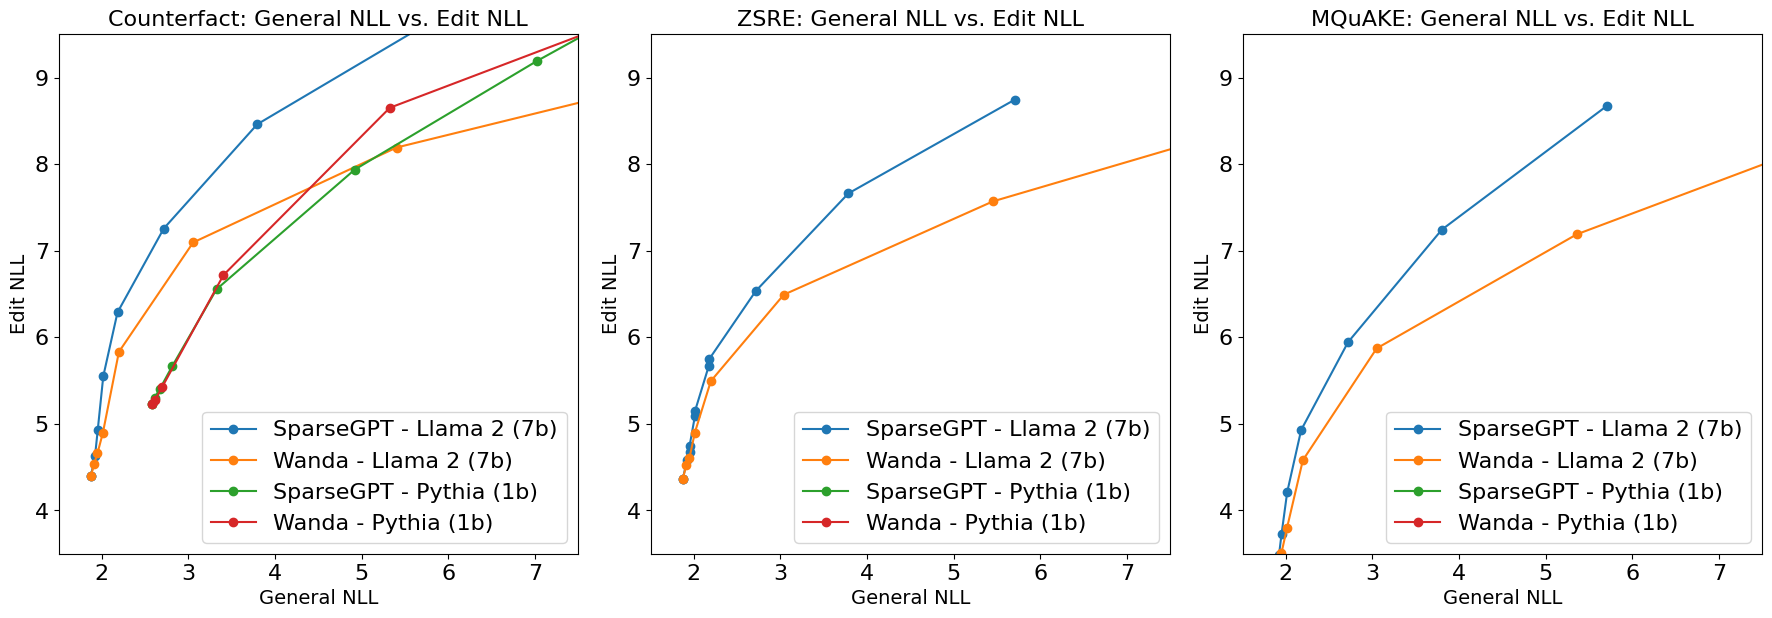

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

# Increase font sizes globally
mpl.rcParams['font.size'] = 16  # Adjust the base font size
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 16

def create_ppl_vs_edit_ppl_plots(dfs, titles, included_models, included_methods):
    """
    Creates a row of subplots for PPL vs. edit PPL for each given DataFrame.

    Parameters:
    dfs (list of pandas.DataFrame): List of DataFrames containing the experiment data.
    titles (list of str): List of titles for each DataFrame.
    included_models (list of str): List of model names to include in the plots.
    included_methods (list of str): List of method names to include in the plots.
    """
    num_dfs = len(dfs)
    fig, axs = plt.subplots(1, num_dfs, figsize=(6 * num_dfs, 18))

    for i, df in enumerate(dfs):
        ax = axs[i] if num_dfs > 1 else axs

        # Filter DataFrame based on included models and methods
        df_filtered = df[df['model'].isin(included_models) & df['method_name'].isin(included_methods)]

        for model in included_models:
            for method in included_methods:
                if method in df_filtered['method_name'].unique():
                    model_method_data = df_filtered[(df_filtered['model'] == model) & 
                                                    (df_filtered['method_name'] == method) & 
                                                    (df_filtered['PPl edits unmasked_mean'] < np.inf)]

                    # Identify and append the baseline value
                    baseline_row = df_filtered[(df_filtered['model'] == model) & 
                                               ~df_filtered['compress']]
                    model_method_data = pd.concat([baseline_row, model_method_data])

                    # Sort by PPL_mean
                    model_method_data_sorted = model_method_data.sort_values(by='PPL_mean')

                    ax.errorbar(np.log(model_method_data_sorted['PPL_mean']), 
                                np.log(model_method_data_sorted['PPl edits unmasked_mean']), 
                                fmt='o-', label=f'{method} - {model}', capsize=5)

        ax.set_xlabel('General NLL')
        ax.set_ylabel('Edit NLL')
        ax.set_title(f'{titles[i]}: General NLL vs. Edit NLL')
        ax.legend()
        ax.grid(False)

        ax.axis('square')
        ax.set_ylim(3.5, 9.5)
        ax.set_xlim(1.5, 7.5)
        ax.plot()
    plt.tight_layout()
    plt.savefig('figures/NLL.pdf', format='pdf', dpi=300)  # Save as PDF
    plt.show()

# Example usage
included_models = ['Llama 2 (7b)', 'Pythia (1b)']
included_methods = ['SparseGPT', 'Wanda']  # Replace with the methods you want to include
dfs = [edited_counterfact, edited_zsre, edited_mq]
titles = ["Counterfact", "ZSRE", "MQuAKE"]
create_ppl_vs_edit_ppl_plots(dfs, titles, included_models, included_methods)


### Order variance

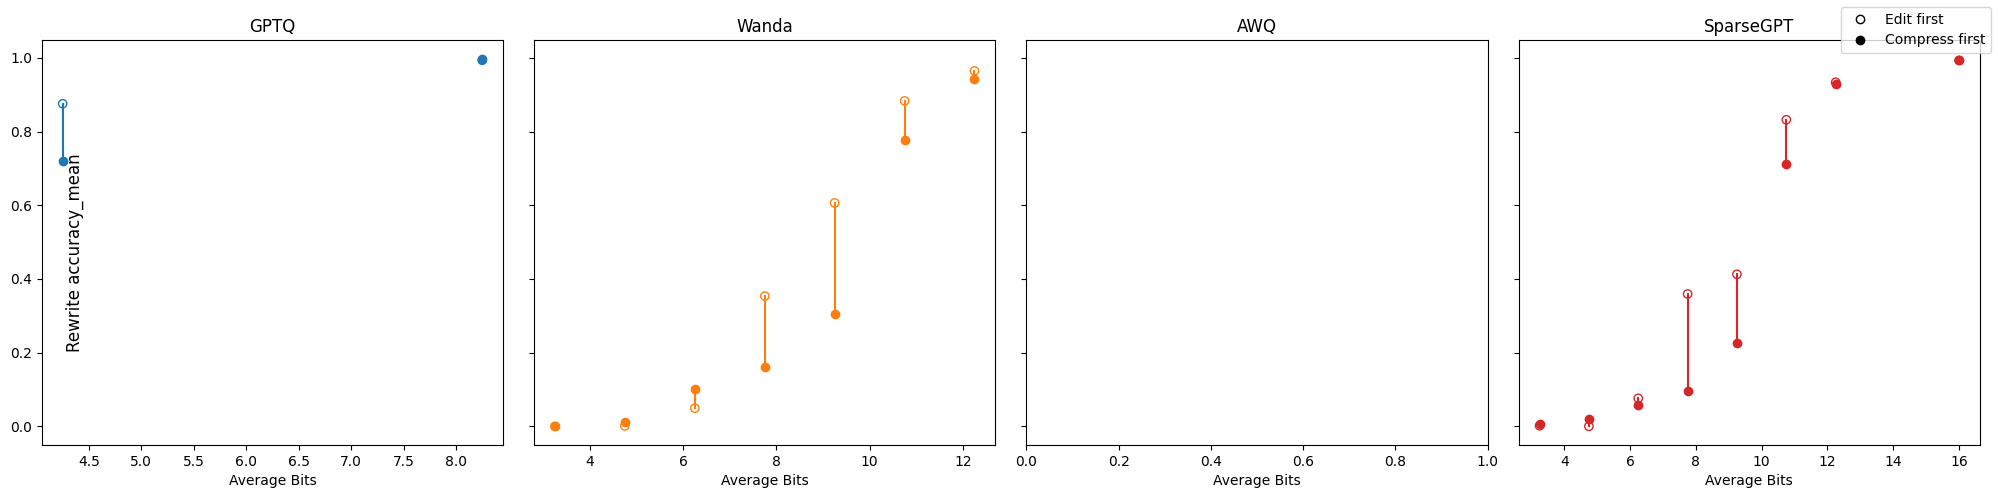

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines

def plot_ppl_comparison_by_method(df1, df2, selected_model, metric):
    """
    Creates a grid of subplots comparing a specified metric for each method_name and Average bits pair
    between two DataFrames for a selected model, using different markers for each DataFrame.
    Each subplot represents a different method.

    Parameters:
    df1, df2 (pandas.DataFrame): The two DataFrames containing the experiment data.
    selected_model (str): The model to filter the data by.
    metric (str): The metric to plot on the y-axis.
    """
    # Filter DataFrames based on the selected model
    df1_filtered = df1[df1['model'] == selected_model]
    df2_filtered = df2[df2['model'] == selected_model]

    # Get unique method names
    methods = set(df1_filtered['method_name']).union(df2_filtered['method_name'])
    num_methods = len(methods)

    # Set up the subplot grid
    fig, axs = plt.subplots(1, num_methods, figsize=(5 * num_methods, 5), sharey=True)

    # Assign colors to each method
    colors = list(mcolors.TABLEAU_COLORS)  # or any other palette of your choice
    method_colors = {method: colors[i % len(colors)] for i, method in enumerate(methods)}

    for ax, method_name in zip(axs, methods):
        # Filter data for this method
        df1_method = df1_filtered[df1_filtered['method_name'] == method_name]
        df2_method = df2_filtered[df2_filtered['method_name'] == method_name]

        # Iterate through each unique avg_bits in df1
        for _, row1 in df1_method.iterrows():
            avg_bits_1 = row1['Average bits']
            metric_value_1 = row1[metric]

            # Find matching avg_bits in df2 within 5% range
            for _, row2 in df2_method.iterrows():
                avg_bits_2 = row2['Average bits']
                metric_value_2 = row2[metric]

                if abs(avg_bits_1 - avg_bits_2) / avg_bits_1 <= 0.05:
                    # Plot the points and connect them with a line
                    ax.plot([avg_bits_1, avg_bits_2], [metric_value_1, metric_value_2],
                            marker='None', linestyle='-', color=method_colors[method_name])
                    ax.scatter([avg_bits_1], [metric_value_1], facecolors='none', edgecolors=method_colors[method_name])
                    ax.scatter([avg_bits_2], [metric_value_2], color=method_colors[method_name])
                    break

        # Configure subplot
        ax.set_title(method_name)
        ax.set_xlabel('Average Bits')
        ax.grid(False)

    # Common ylabel
    fig.text(0.04, 0.5, metric, va='center', ha='center', rotation='vertical', fontsize=12)

    # Create custom legend for markers
    custom_legend = [mlines.Line2D([0], [0], color='black', marker='o', linestyle='None', markerfacecolor='none', label='Edit first'),
                     mlines.Line2D([0], [0], color='black', marker='o', linestyle='None', markerfacecolor='black', label='Compress first')]
    fig.legend(handles=custom_legend, loc='upper right')
    plt.tight_layout()
    plt.show()

# Example usage
selected_model = 'Llama 2 (7b)'
metric = 'Rewrite accuracy_mean'  # Replace with your metric, e.g., 'PPL_mean'
plot_ppl_comparison_by_method(edited_counterfact, compfirst_counterfact, selected_model, metric)
